In [1]:
import numpy as np
from skimage import io, draw, measure, morphology
from matplotlib import pyplot as plt
import torch

from loader.base import BaseMatchDataset
from loader import utils
import tqdm
import time
import os
import h5py
from multiprocessing import Pool

from papyrus_matching.train import LitPapyrusTR
from loader.base import process_pair

In [1]:
%cd ..

/raid/homes/nicola.messina/workspace/papyri/papyrus-matching


/raid/homes/nicola.messina/anaconda3/envs/papyri/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
class InferenceDataset(torch.utils.data.Dataset):
    def __init__(self, rgba_path_a, rgba_path_b, side=384, transform=None, mask_transform=None, perimeter_points=64, pad=15):
        self.mask_transform = mask_transform
        self.transform = transform
        self.side = side
        self.perimeter_points = perimeter_points
        self.pad = pad
        self.rgba_path_a = rgba_path_a
        self.rgba_path_b = rgba_path_b

        # Extract one contour from each image's alpha channel
        self.contour_a = self.get_contour_from_alpha(rgba_path_a)
        self.contour_b = self.get_contour_from_alpha(rgba_path_b)

        # Get touch points between the two specific contours
        self.touch_points = self.get_all_touch_points(
            self.contour_a, self.contour_b, 
            pad=self.pad, force=False
        )
        # Note: self.filter_touch_points call is removed as it's no longer applicable.

    def get_contour_from_alpha(self, image_path, pad_amount=(10, 10)):
        """
        Loads an RGBA image, extracts the alpha channel, and finds the 
        main exterior contour using the robust logic from find_main_contours.
        """
        try:
            rgba = io.imread(image_path)
        except FileNotFoundError:
            print(f"[ERROR] Image not found at {image_path}")
            return np.empty((0, 2), dtype=float)

        if rgba.shape[2] != 4:
            print(f"[ERROR] Image at {image_path} is not RGBA.")
            return np.empty((0, 2), dtype=float)
            
        # 1. Binarize from alpha channel (alpha > 0)
        binary = rgba[:, :, 3] > 0
        
        # 2. Pad
        binary = np.pad(binary, pad_amount, mode='constant', constant_values=0)
        
        # 3. Morphological closing
        binary = morphology.binary_closing(binary, morphology.disk(1))

        # 4. Label regions
        labels = measure.label(binary)
        region_props = measure.regionprops(labels, intensity_image=binary)

        if not region_props:
            print(f"[WARNING] No regions found in alpha channel of {image_path}")
            return np.empty((0, 2), dtype=float)

        # 5. Get largest region prop
        prop = max(region_props, key=lambda x: x.area)

        # 6. Fill holes
        # find perimeter contour of the region prop, ignoring holes
        binary_filled = morphology.remove_small_holes(labels == prop.label, area_threshold=1000)
        
        # 7. Find contours
        contours = measure.find_contours(binary_filled, 0.5)

        if not contours:
            print(f"[WARNING] No contours found after processing {image_path}")
            return np.empty((0, 2), dtype=float)

        # 8. Get the longest contour (this is the exterior one)
        contour = max(contours, key=len)
        
        # 9. Remove padding
        contour -= np.array(pad_amount)

        return contour
    
    def get_all_touch_points(self, contour_a, contour_b, pad=15, force=False):
        """ Get all touch points between two specific contours. """

        if contour_a.shape[0] < 2 or contour_b.shape[0] < 2:
            print("[WARNING] Not enough contour data to find contact points.")
            return np.empty((0, 4, 2), dtype=float)

        # Create a single pair to process: (idx_a, idx_b, contour_a, contour_b, ...)
        # We use 0 and 1 as the dummy indices
        pairs = [(0, 1, contour_a, contour_b, self.perimeter_points, pad)]
        
        with Pool(os.cpu_count()) as pool:
            all_contacts_list = pool.map(process_pair, pairs)

        all_contacts = np.vstack([c for c in all_contacts_list]) if all_contacts_list else np.empty((0, 4, 2), dtype=float)
        return all_contacts

    def __len__(self):
        return len(self.touch_points)

    def __getitem__(self, idx):
        # load both images
        rgba_a = io.imread(self.rgba_path_a)
        rgba_b = io.imread(self.rgba_path_b)

        # get contours and touch points
        _, a_contact, b_contact, delta = self.touch_points[idx]
        
        a_contour = self.contour_a
        b_contour = self.contour_b

        def _get_blit_slices(t_vec, src_shape, dst_shape):
            """
            Helper function to calculate clipped source and destination slices for blitting.
            """
            src_h, src_w = src_shape[:2]
            dst_h, dst_w = dst_shape[:2]
            t_y, t_x = np.floor(t_vec).astype(int)

            # Calculate source slice (from rgba_a or rgba_b)
            src_y_start = max(0, -t_y)
            src_x_start = max(0, -t_x)
            src_y_end = min(src_h, dst_h - t_y)
            src_x_end = min(src_w, dst_w - t_x)
            
            # Calculate destination slice (on crop_rgba)
            dst_y_start = max(0, t_y)
            dst_x_start = max(0, t_x)
            dst_y_end = min(dst_h, t_y + src_h)
            dst_x_end = min(dst_w, t_x + src_w)

            # Check for non-overlapping (empty) slices
            if src_y_start >= src_y_end or src_x_start >= src_x_end or \
               dst_y_start >= dst_y_end or dst_x_start >= dst_x_end:
                return None, None

            src_slice = (slice(src_y_start, src_y_end), slice(src_x_start, src_x_end))
            dst_slice = (slice(dst_y_start, dst_y_end), slice(dst_x_start, dst_x_end))
            
            return src_slice, dst_slice

        # find the coordinates of pixels to copy from the original image
        def _prepare_patch(cropped):
            if cropped:
                side = self.side
            else:
                width_a = a_contour[:, 1].max() - a_contour[:, 1].min()
                width_b = b_contour[:, 1].max() - b_contour[:, 1].min()
                height_a = a_contour[:, 0].max() - a_contour[:, 0].min()
                height_b = b_contour[:, 0].max() - b_contour[:, 0].min()
                side = int(np.ceil(max(width_a + width_b, height_a + height_b))) + 2 * self.pad

            # make empty transparent images
            shape = (side, side, 4)
            shape_mask = (side, side)
            crop_a_only = np.zeros(shape, dtype=np.uint8)
            crop_b_only = np.zeros(shape, dtype=np.uint8)

            half_side = side // 2
            half_delta = delta / 2

            # move the contours such that they are centered in the crop
            t_a = - a_contact + half_side - self.pad * half_delta
            t_b = - b_contact + (side - half_side) + self.pad * (delta - half_delta)

            # --- OPTIMIZATION: Blit piece A ---
            src_a_slice, dst_a_slice = _get_blit_slices(t_a, rgba_a.shape, shape)
            if src_a_slice:
                src_patch = rgba_a[src_a_slice]
                dst_region = crop_a_only[dst_a_slice]
                
                # Composite using alpha channel as mask
                mask = src_patch[:, :, 3] > 0
                dst_region[mask] = src_patch[mask]
                crop_a_only[dst_a_slice] = dst_region

            # --- OPTIMIZATION: Blit piece B ---
            src_b_slice, dst_b_slice = _get_blit_slices(t_b, rgba_b.shape, shape)
            if src_b_slice:
                src_patch = rgba_b[src_b_slice]
                dst_region = crop_b_only[dst_b_slice]

                # Composite using alpha channel as mask
                mask = src_patch[:, :, 3] > 0
                dst_region[mask] = src_patch[mask]
                crop_b_only[dst_b_slice] = dst_region
            
            # --- Combine the two pieces ---
            # Create the final composite image by overlaying B onto A
            crop_rgba = crop_a_only.copy()
            mask_b_full = crop_b_only[:, :, 3] > 0
            crop_rgba[mask_b_full] = crop_b_only[mask_b_full]

            if cropped and self.transform:
                # --- OPTIMIZATION: Get masks from blitted images ---
                # Use the alpha channels of the separate patches as masks
                mask_a = (crop_a_only[:, :, 3] > 0).astype(np.float32)
                mask_b = (crop_b_only[:, :, 3] > 0).astype(np.float32)
                
                mask_a = self.mask_transform(mask_a[:, :, None])
                mask_b = self.mask_transform(mask_b[:, :, None])
                
                # Apply original logic: transform composite, then split
                transformed_composite = self.transform(crop_rgba)
                crop_a = transformed_composite * mask_a
                crop_b = transformed_composite * mask_b
                crop_rgba = crop_a + crop_b
                
            # --- Bug fix (same as before) ---
            if cropped and self.transform:
                zero_alpha = crop_rgba[3, :, :] == 0
                crop_rgba[:3, zero_alpha] = 0
            else:
                zero_alpha = crop_rgba[:, :, 3] == 0
                crop_rgba[zero_alpha, :3] = 0

            return crop_rgba

        cropped_patch = _prepare_patch(cropped=True)
        full_image = _prepare_patch(cropped=False)

        return cropped_patch, full_image

In [9]:
root = 'data/for_inference'
image_name_a = root + "/test_fragment_easy1_L.png"
image_name_b = root + "/test_fragment_easy1_R.png"

from torchvision import transforms as T
transf = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
])
mask_transf = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
])
dset = InferenceDataset(image_name_a, image_name_b, pad=25, perimeter_points=128, transform=transf, mask_transform=mask_transf)

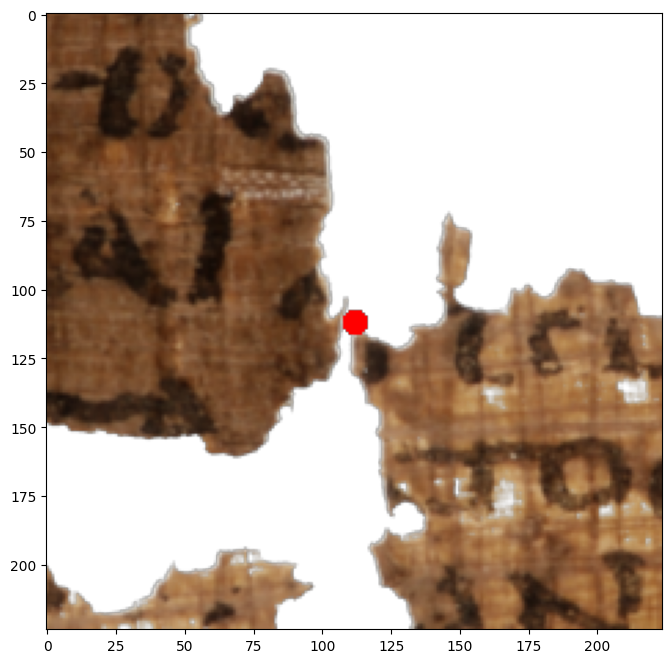

In [4]:
# show images organizing them in a grid
fig = plt.figure(figsize=(8, 8))
num_samples = min(100, len(dset))

data = dset[17]
patch, image = data
patch = (patch.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
# image = (image.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

# draw a red dot at the center of the mask and rgba
center = (patch.shape[0] // 2, patch.shape[1] // 2)
rr, cc = draw.disk(center, 5, shape=patch.shape[:2])
patch[rr, cc] = [255, 0, 0, 255]

ax = fig.add_subplot(1, 1, 1)
ax.imshow(patch)    

In [5]:
# load the model
model_path = "runs/lightning_logs/version_3/checkpoints/epoch=26-step=4293.ckpt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LitPapyrusTR.load_from_checkpoint(model_path)
encoder = model.eval().to(device)


100%|██████████| 100/100 [04:18<00:00,  2.59s/it]


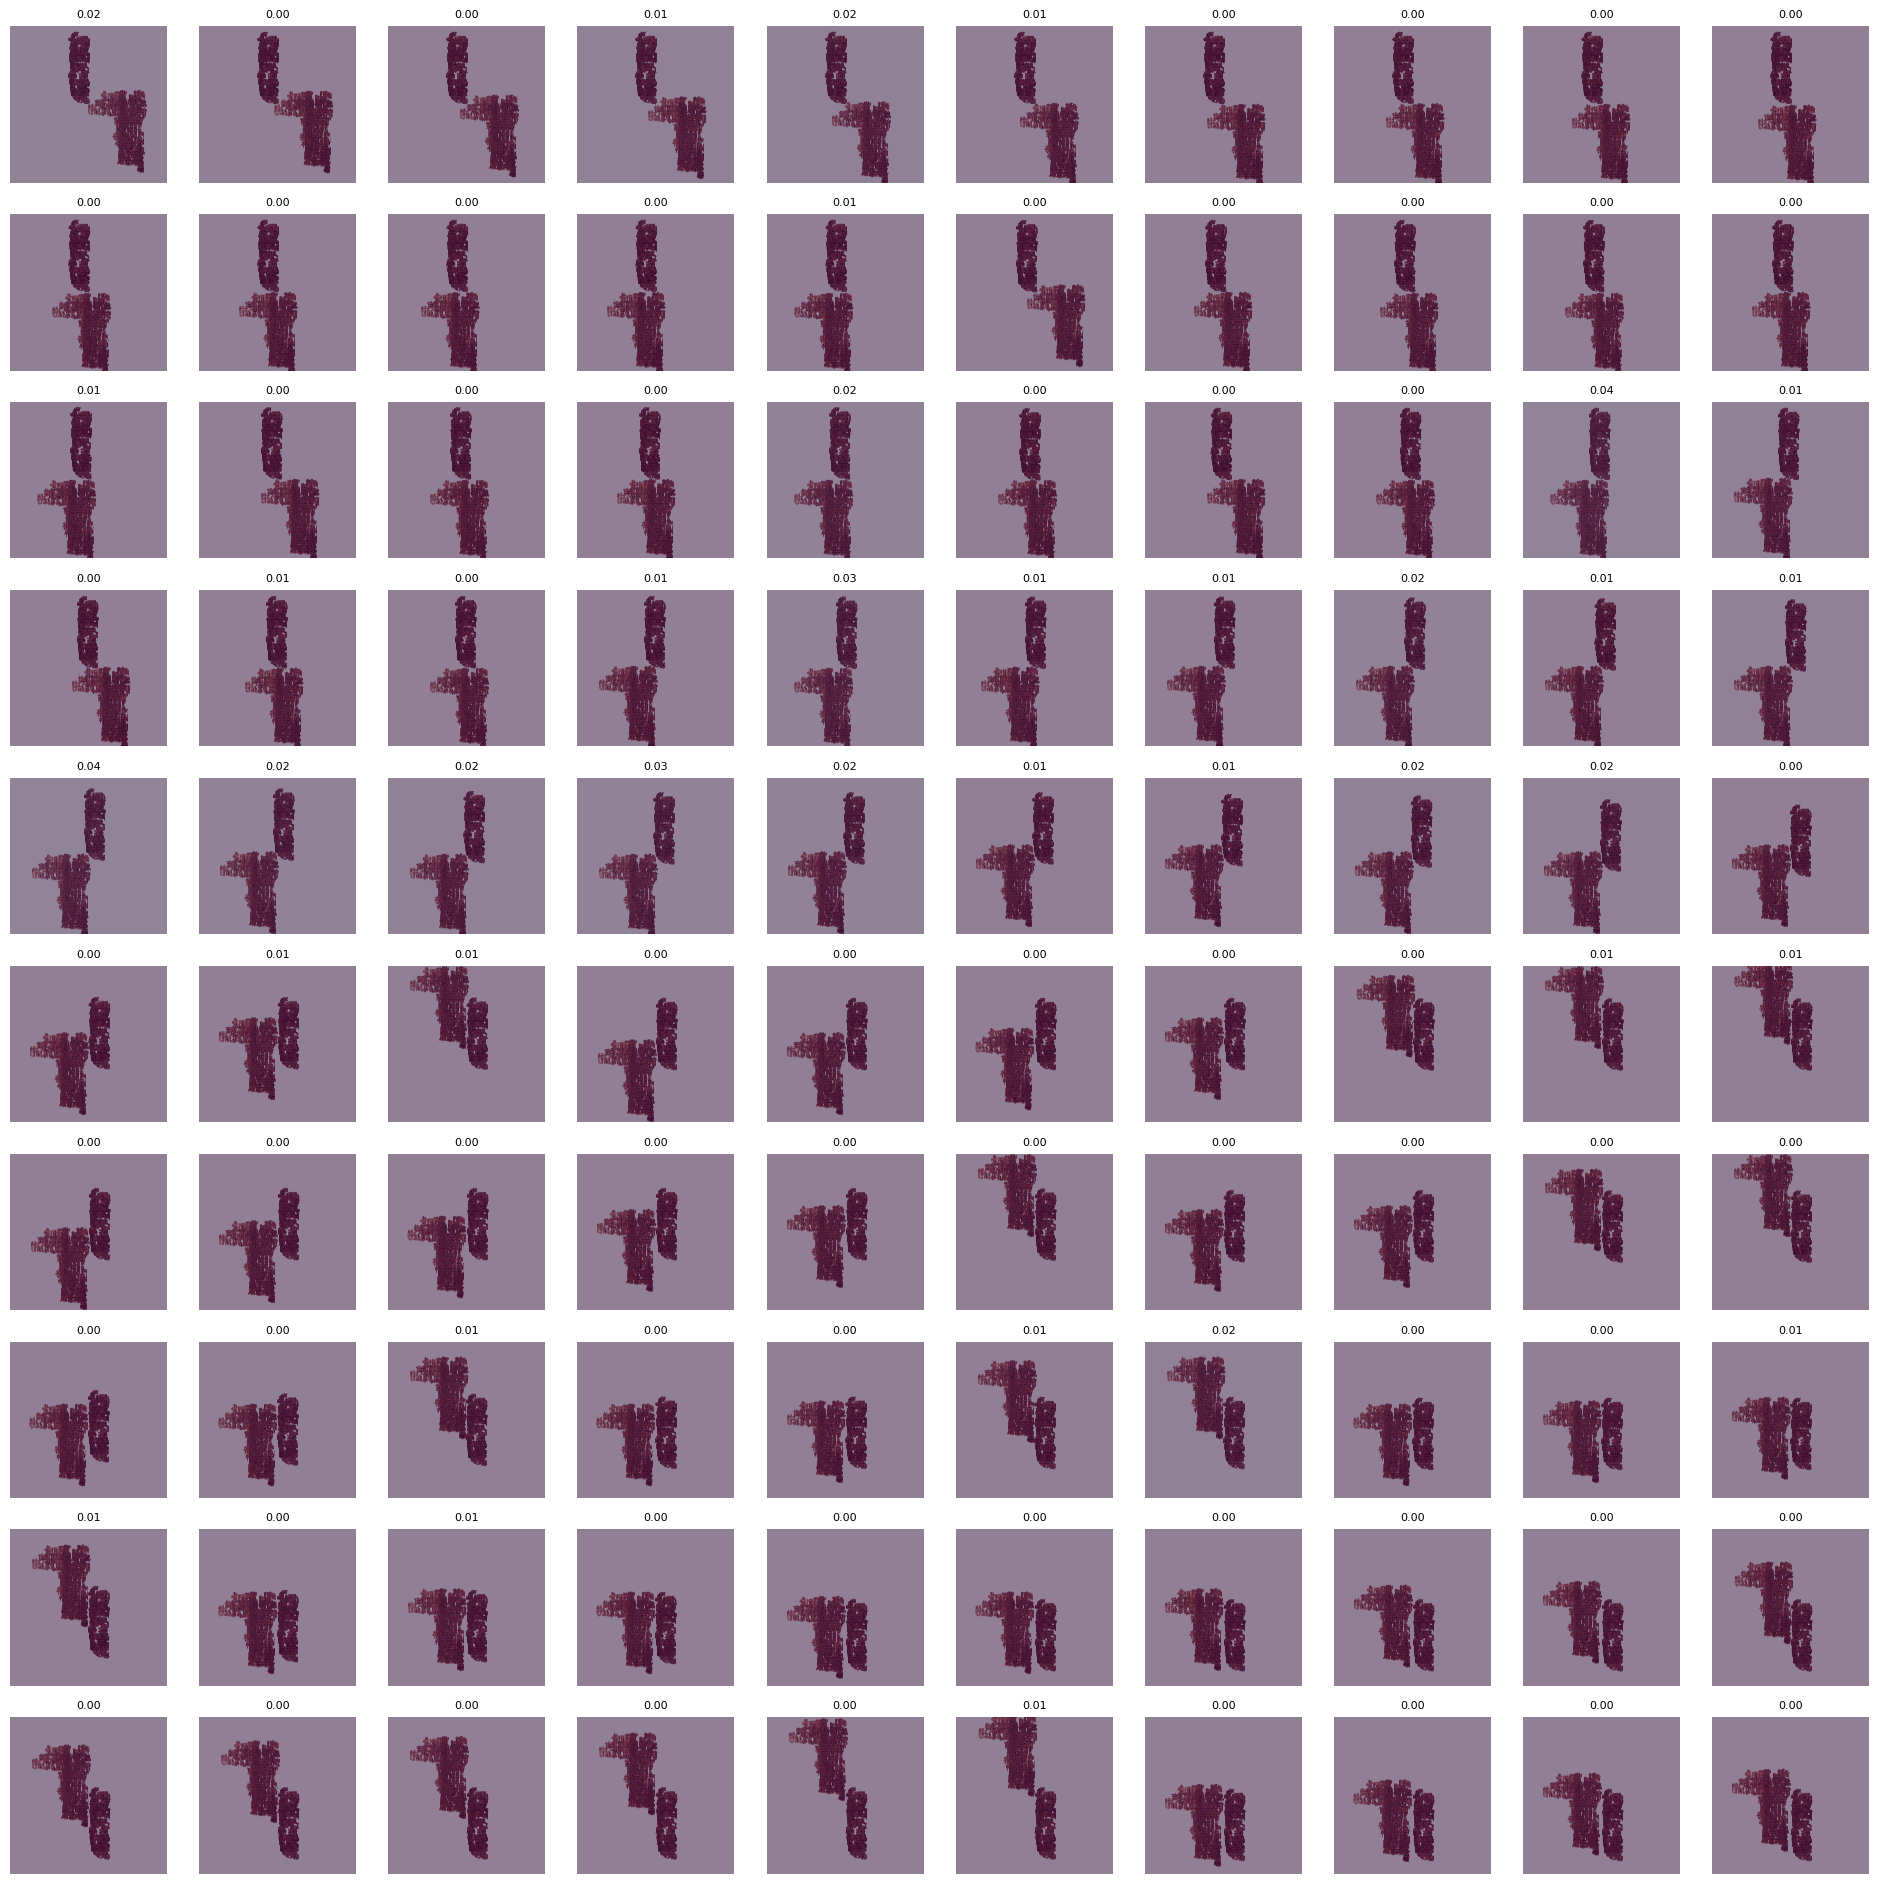

In [10]:
# show images organizing them in a grid
fig = plt.figure(figsize=(24, 24))
num_samples = min(100, len(dset))

for i in tqdm.trange(num_samples):
    start = time.time()
    data = dset[i]
    end_loading = time.time()
    patch, image = data
    # patch = (patch.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
    # image = (image.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

    # draw a red dot at the center of the mask and rgba
    # center = (patch.shape[0] // 2, patch.shape[1] // 2)
    # rr, cc = draw.disk(center, 5, shape=patch.shape[:2])
    # patch[rr, cc] = [255, 0, 0, 255]

    score = encoder(patch.unsqueeze(0).to(device))
    score = torch.sigmoid(score).squeeze().cpu().item()
    end_inference = time.time()
    # print(f"Loading time: {end_loading - start:.3f}s, Inference time: {end_inference - end_loading:.3f}s")

    ax = fig.add_subplot(10, 10, i + 1)
    # disable axis
    ax.axis('off')
    color = plt.cm.viridis(score)
    color = np.concatenate((color[:3], [1.0]))
    # add the color to the image, with 0.5 alpha
    image = (0.5 * image + 0.5 * np.array(color[None, None, :]) * 255).astype(np.uint8)
    ax.set_title(f"{score:.2f}", fontdict={'size': 8})
    ax.imshow(image)